In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#here set up the path of your file, a priori it should be on same directory
data = pd.read_csv("ibtracs.last3years.list.v04r00.csv") 
# Preview the first 5 lines of the loaded data 
data.head()

/Users/leobix/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1,2,8,9,14,19,20,25,161,162) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,,Year,,,,,,,degrees_north,degrees_east,...,second,kts,second,ft,nmile,nmile,nmile,nmile,kts,degrees
1,2016005N02187,2016,1,EP,CP,PALI,2016-01-05 06:00:00,NR,2.00000,-173.500,...,,,,,,,,,3,73
2,2016005N02187,2016,1,EP,CP,PALI,2016-01-05 09:00:00,NR,2.04500,-173.353,...,,,,,,,,,3,71
3,2016005N02187,2016,1,EP,CP,PALI,2016-01-05 12:00:00,NR,2.10000,-173.200,...,,,,,,,,,3,67
4,2016005N02187,2016,1,EP,CP,PALI,2016-01-05 15:00:00,NR,2.17750,-173.042,...,,,,,,,,,4,56


In [4]:
#allows to keep only specific columns
def select_data(data):
    return data[['SID', 'NUMBER', 'ISO_TIME', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND', 'STORM_SPEED', 'STORM_DIR']]

#convert columns to numeric values
#and interpolate missing values
def numeric_data(data):
    for i in ['LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND', 'STORM_SPEED', 'STORM_DIR']:
        data[i]=pd.to_numeric(data[i],errors='coerce')
        data[i]=data[i].interpolate(method='linear')
    return data

# df0 is  cleaned data 
df0 = select_data(data)
df0 = numeric_data(df0)

/Users/leobix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/leobix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [23]:
def sort_storm(data, min_wind, min_steps = 10):
    '''function to create dictionary of storm matrices
    arguments: 
    data we want to cut
    min_wind: the minimum wind speed to store data 
    '''
    #get unique storm_id:
    SID=pd.unique(data['SID']).tolist()
    #remove empty SID
    SID.remove(' ') 
    #create empty dictionary
    dict0={}
    ind = 0
    for i in range(len(SID)):
        #get data of a particular SID
        M = data.loc[data['SID'] == SID[i]]
        #cut off using min wind speed 
        M = M.loc[M['WMO_WIND'] >= min_wind]
        #save matrix in dict0
        if M.shape[0] > min_steps:
            ind+=1
            dict0.update({ind:M})
        #dict0[i] = M
    return dict0

#storms is the dictionary all storm matrices
storms = sort_storm(df0,min_wind=50)

In [24]:
#function to calculate tensor shape
    #input: dictionary of storm data
def tensor_shape(dict0):
    #number of storms
    num_storms=len(dict0) 
    #number of features
    num_features=dict0[next(iter(dict0))].shape[1]  
    
    #to compute min and max number of steps
    t_max = 0 #initialise 
    t_min = 100
    for i in dict0:
        t0 = dict0[i].shape[0]
        if t0 == 0:
            print(dict0[i])
        if  t0 > t_max:
            t_max = t0
        if t0 < t_min:
            t_min = t0
    print("There are %s storms with %s features, and maximum number of steps is %s and minimum is %s." %(num_storms,num_features,t_max, t_min))
    return num_storms, num_features, t_max, t_min     
    
#call tensor_shape 
m, n, t_max, t_min = tensor_shape(storms)

There are 113 storms with 10 features, and maximum number of steps is 129 and minimum is 11.


In [25]:
storms[25]

,SID,NUMBER,ISO_TIME,LAT,LON,WMO_WIND,WMO_PRES,DIST2LAND,STORM_SPEED,STORM_DIR
3136,2016237N14253,54,2016-08-25 18:00:00,16.6000,-113.000,50.0,1001.0,771.0,6.0,286.0
3137,2016237N14253,54,2016-08-25 21:00:00,16.6924,-113.308,50.0,1001.0,774.0,6.0,289.0
3138,2016237N14253,54,2016-08-26 00:00:00,16.8000,-113.600,50.0,1001.0,779.0,6.0,294.0
3139,2016237N14253,54,2016-08-26 03:00:00,16.9425,-113.908,50.0,1001.0,785.0,6.0,298.0
3140,2016237N14253,54,2016-08-26 06:00:00,17.1000,-114.200,50.0,1001.0,783.0,6.0,301.0
3141,2016237N14253,54,2016-08-26 09:00:00,17.2574,-114.450,52.5,999.0,782.0,6.0,302.0
3142,2016237N14253,54,2016-08-26 12:00:00,17.4000,-114.700,55.0,997.0,786.0,6.0,296.0
3143,2016237N14253,54,2016-08-26 15:00:00,17.5074,-114.978,57.5,995.5,797.0,6.0,289.0
3144,2016237N14253,54,2016-08-26 18:00:00,17.6000,-115.300,60.0,994.0,810.0,7.0,287.0
3145,2016237N14253,54,2016-08-26 21:00:00,17.7150,-115.685,62.5,991.5,831.0,8.0,285.0


In [ ]:
# ------ up to here------ dstack doesn't work because dimensions don't agree
    #need to make all matrices m,n size, fill empty spots with zero, and then stack them 
np.dstack((storms[1],storms[2]))

In [26]:
#create a tensor
def create_tensor(data):
    tensor = data[0]
    for i in range(2,m,1):
        tensor=np.dstack(tensor, data[i])
    return tensor   

create_tensor(data)

KeyError: 0

In [ ]:
#to use in the future: computes the wind category
def sust_wind_to_cat(wind):
    # maximum sustained wind in kt (knot)
    if wind<=33: cat='TD' # <=33
    elif wind<=63.:  cat='TS'
    elif wind <=82.: cat='H1'
    elif wind <=95.: cat='H2'
    elif wind <=112.: cat='H3'
    elif wind <=136.: cat='H4'
    else: cat='H5'

    return cat

In [193]:
#allows to keep only the data between two dates to specify
def get_periodic_data(data, start ='2018-01-01',end ='2018-12-31',mincat=None,maxcat=None):
    n = len(data)
    start = datetime.strptime(start, '%Y-%m-%d')
    end = datetime.strptime(end, '%Y-%m-%d')
    times = pd.to_datetime(data['ISO_TIME'][1:n])
    ind_start = 1
    ind_end = n
    i = 1
    while times[i] < start :#or i < n:
        i+=1
    ind_start = i
    while times[i] < end :#or i < n:
        i+=1
    ind_end = i
    return data[ind_start:ind_end]

In [190]:
#allows to get the distinct ids of the storms 
def get_ids(data):
    return data.SID.unique()

In [6]:
def get_storm_track(data, storm_id = '2016005N02187', time_step = 6):
    #data.set_index("SID", inplace=True)
    return data.loc[data['SID'] == storm_id]

In [8]:
storm = get_storm_track(data)
lat = np.array(storm['LAT'])
lat2 = [float(lat[i]) for i in range(len(lat))]
lon = np.array(storm['LON'])
lon2 = [float(lon[i]) for i in range(len(lon))]

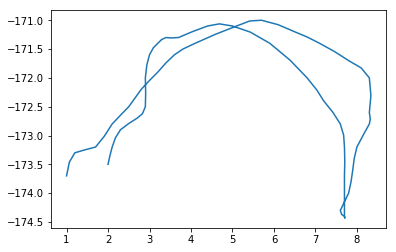

In [9]:
plt.plot(lat2, lon2)
plt.show()